# FPL Player Performance Analysis & Optimization

As football season reached its last international break of the 2024, it proves to be a good point to reflect on the start of the season. With 11 gameweeks done, some data has been accumulated already. After pretty mid start to the season and being behind almost 100 points from the top of the mates league, the current international break allows to look back at the specific trends and patterns from the start of the season in order to look at the tendecies in order to turn the fortunes around for the remainder of the season.

The aim is to analyze the player performance data to try and optimize the decision-making for the future gameweeks, whilst focusing on the player performance, cost efficiency and consistency across the different positions. 

### Data Collection & Preprocessing

First and foremost, it is all about getting the right data. Fantasy Premier League provides direct access to multiple API endpoints. To access the general information 'bootstrap-static' is used (https://www.game-change.co.uk/2023/02/10/a-complete-guide-to-the-fantasy-premier-league-fpl-api/).

In [83]:
import requests
import pandas as pd

base_url = 'https://fantasy.premierleague.com/api/'
request = requests.get(base_url + 'bootstrap-static/')
data = request.json()

In order to collect all the necessary data, we need to fetch the data about teams, players and individual gameweek performance data.

In [84]:
players_df = pd.DataFrame(data['elements'])
teams_df = pd.DataFrame(data['teams'])
positions_df = pd.DataFrame(data['element_types'])

In [85]:
teams_df = teams_df[['id', 'name']].rename(columns={'id': 'team_id', 'name': 'team_name'})
positions_df = positions_df[['id', 'singular_name']].rename(columns={'id': 'position_id', 'singular_name': 'position_name'})

players_df = players_df[['id', 'web_name', 'team', 'element_type', 'now_cost', 'total_points', 'minutes', 'points_per_game', 'value_season', 'selected_by_percent']]
players_df['now_cost'] = players_df['now_cost'] / 10
players_df = players_df.rename(columns={'id': 'player_id', 'team': 'team_id', 'element_type': 'position_id', 'value_season': 'value_season', 'selected_by_percent': 'selected_by'})

In [87]:
def get_gameweek_data(player_id):
    url = f"https://fantasy.premierleague.com/api/element-summary/{player_id}/"
    response = requests.get(url)
    history = response.json().get('history', [])
    history_df = pd.DataFrame(history)

    if not history_df.empty:
        history_df = history_df[['round', 'total_points', 'minutes', 'value']]
        history_df['player_id'] = player_id
        history_df = history_df.rename(columns={'round': 'gameweek', 'value': 'value'})
    return history_df

gameweek_data_list = []
for player_id in players_df['player_id']:
    gameweek_data_list.append(get_gameweek_data(player_id))

gameweek_data_df = pd.concat(gameweek_data_list, ignore_index=True)

After getting the data into dataframes, next up it was adjusted into the SQL database using the sqlite3 Python library. The following structure of tables is proposed in order to maintain clarity and best database practices: https://docs.python.org/3/library/sqlite3.html

In [88]:
import sqlite3
con = sqlite3.connect("data.db")
cur = con.cursor()

In [94]:
cur.execute('''CREATE TABLE Teams(
                team_id INTEGER,
                team_name VARCHAR(100),
                CONSTRAINT team_pk PRIMARY KEY(team_id)
            )''')
con.commit()

In [95]:
cur.execute('''CREATE TABLE Positions(
                position_id INTEGER,
                position_name VARCHAR(100),
                CONSTRAINT position_pk PRIMARY KEY(position_id)
            )''')
con.commit()

In [96]:
cur.execute('''CREATE TABLE Players(
                player_id INTEGER,
                web_name VARCHAR(100),
                team_id INTEGER,
                position_id INTEGER,
                now_cost DECIMAL(5,2),
                total_points INTEGER,
                minutes INTEGER,
                points_per_game DECIMAL(4,2),
                value_season DECIMAL(4,2),
                selected_by DECIMAL(4,2),
                CONSTRAINT player_pk PRIMARY KEY(player_id),
                CONSTRAINT team_fk FOREIGN KEY(team_id) REFERENCES Teams(team_id),
                CONSTRAINT position_fk FOREIGN KEY(position_id) REFERENCES Positions(position_id)
            )''')
con.commit()

In [97]:
cur.execute('''CREATE TABLE Gameweeks(
                id INTEGER,
                player_id INTEGER,
                gameweek INTEGER,
                total_points INTEGER,
                minutes INTEGER,
                value DECIMAL(5,2),
                team_id INTEGER,
                CONSTRAINT row_pk PRIMARY KEY(id),
                CONSTRAINT player_fk FOREIGN KEY(player_id) REFERENCES Players(player_id),
                CONSTRAINT team_fk FOREIGN KEY(team_id) REFERENCES Teams(team_id)
            )''')
con.commit()

After creating the tables, data from the existing dataframes was injected into created tables.

In [98]:
teams_df.to_sql('Teams', con, if_exists='replace', index=False)
positions_df.to_sql('Positions', con, if_exists='replace', index=False)
players_df.to_sql('Players', con, if_exists='replace', index=False)
gameweek_data_df.to_sql('Gameweeks', con, if_exists='replace', index=False)

7230

To manage the negative outliers and empty values it is necessary to introduce the filter criteria, because around a third of the players in the database have not even played a single minute this season. So, to tackle that, for further analysis only players that have played at least 5 games and 300 minutes are being kept in the dataset.

In [99]:
with con:
    con.execute("""
        DELETE FROM Gameweeks
        WHERE player_id NOT IN (
            SELECT pl.player_id
            FROM Players AS pl
            JOIN (
                SELECT gw.player_id, COUNT(*) AS games_played
                FROM Gameweeks AS gw
                WHERE gw.minutes > 0 
                GROUP BY gw.player_id
                HAVING COUNT(*) >= 5 
            ) AS filtered_players ON pl.player_id = filtered_players.player_id
            WHERE pl.minutes > 300 
        );
    """)

In [100]:
with con:
    con.execute("""
        DELETE FROM Players
        WHERE player_id NOT IN (
            SELECT pl.player_id
            FROM Players AS pl
            JOIN (
                SELECT gw.player_id, COUNT(*) AS games_played
                FROM Gameweeks AS gw
                WHERE gw.minutes > 0 
                GROUP BY gw.player_id
                HAVING COUNT(*) >= 5 
            ) AS filtered_players ON pl.player_id = filtered_players.player_id
            WHERE pl.minutes > 300 
        );
    """)

### Player Performance By Position

In this section, the performance of different player position is analyzed to provide insights into which positions are contributing the most points this season, which may help to guide decisions on prioritizing positions when building and FPL team.

First and foremost the total sum of points scored by players in each position is calculated.

In [101]:
query = """
    SELECT p.position_name, SUM(pl.total_points) AS total_points
    FROM players pl
    JOIN positions p ON pl.position_id = p.position_id
    GROUP BY p.position_name
    ORDER BY total_points DESC;
"""
total_points_by_position = pd.read_sql_query(query, con)
print(total_points_by_position)

  position_name  total_points
0    Midfielder          3639
1      Defender          2267
2       Forward          1143
3    Goalkeeper           699


Importing Seaborn and Matplotlib libraries for visualization

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\VS\AppData\Local\Temp\ipykernel_8840\2063224833.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='position_name', y='total_points', data=total_points_by_position, palette='Set1')


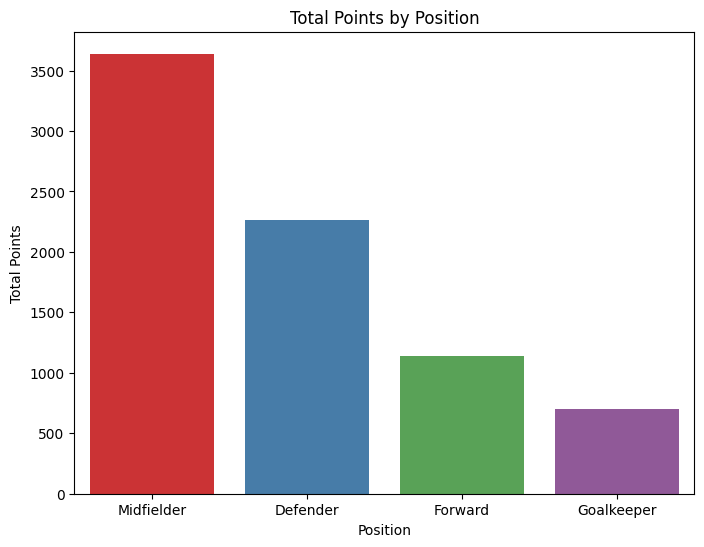

In [103]:
plt.figure(figsize=(8, 6))
sns.barplot(x='position_name', y='total_points', data=total_points_by_position, palette='Set1')
plt.title("Total Points by Position")
plt.xlabel("Position")
plt.ylabel("Total Points")
plt.show()

The distribution between the positions is quite interesting. Midfielders accumulated more points than Defenders and Forwards combined, which suggests that focus on the midfielders might favourable in order to try and maximize the points output of the team. 

Next up, we are looking at the output of each position per single gameweek.

In [104]:
query = """
    SELECT p.position_name, AVG(pl.points_per_game) AS avg_points_per_game
    FROM players pl
    JOIN positions p ON pl.position_id = p.position_id
    GROUP BY p.position_name
    ORDER BY avg_points_per_game DESC;
"""
avg_points_per_game_by_position = pd.read_sql_query(query, con)
print(avg_points_per_game_by_position)

  position_name  avg_points_per_game
0       Forward             4.114286
1    Goalkeeper             3.350000
2    Midfielder             2.856589
3      Defender             2.432990


C:\Users\VS\AppData\Local\Temp\ipykernel_8840\3453829961.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='position_name', y='avg_points_per_game', data=avg_points_per_game_by_position, palette='Set1')


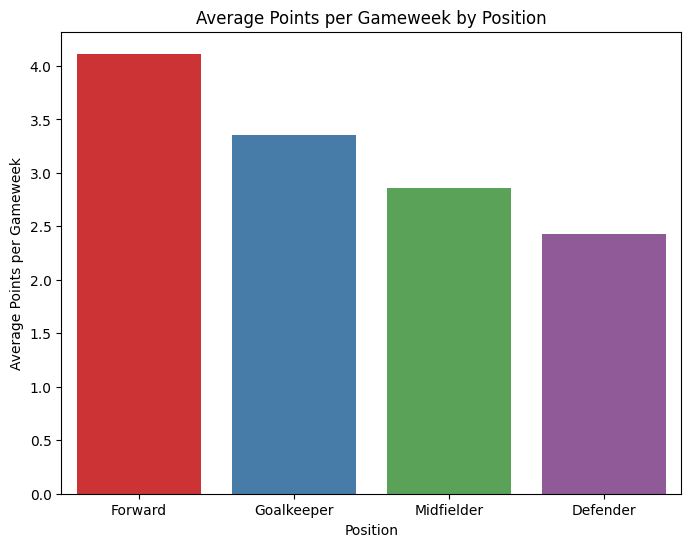

In [105]:
plt.figure(figsize=(8, 6))
sns.barplot(x='position_name', y='avg_points_per_game', data=avg_points_per_game_by_position, palette='Set1')
plt.title("Average Points per Gameweek by Position")
plt.xlabel("Position")
plt.ylabel("Average Points per Gameweek")
plt.show()

Looking at the means, even though in the total standings for the positions performance forwards were the worst performing out of all the outfield players, on a single gameweek basis forwards are performing better. That suggests that the impact of forwards when they play might be more significant to other positions. Same thing with the goalkeepers, even though the have the least amount of total points, the consistency makes up for it on a single gameweek basis.

In order to visualize the distribution of total points across different positions, the boxplot is created.

In [106]:
query = """
    SELECT p.position_name, pl.total_points
    FROM players pl
    JOIN positions p ON pl.position_id = p.position_id;
"""
players_with_positions = pd.read_sql_query(query, con)
print(players_with_positions)

    position_name  total_points
0        Defender            45
1         Forward            46
2        Defender            24
3      Midfielder            47
4      Goalkeeper            42
..            ...           ...
271      Defender            17
272      Defender            10
273       Forward            45
274      Defender            14
275    Midfielder             8

[276 rows x 2 columns]


C:\Users\VS\AppData\Local\Temp\ipykernel_8840\1518810203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='position_name', y='total_points', data=players_with_positions, palette='Set1')


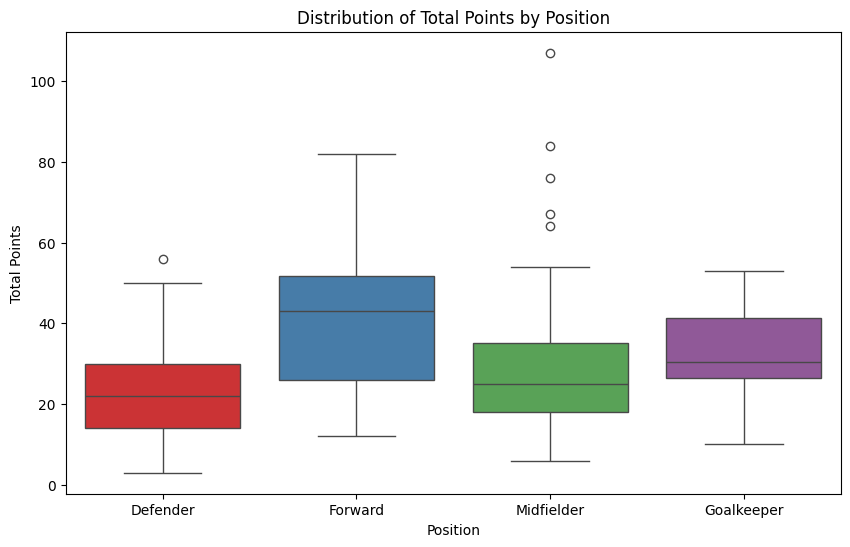

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='position_name', y='total_points', data=players_with_positions, palette='Set1')
plt.title("Distribution of Total Points by Position")
plt.xlabel("Position")
plt.ylabel("Total Points")
plt.show()

Looking at the boxplot, it can be seen that midfielders have by far the most overperforming outliers, with forwards showing the widest range of total points. It is important to note that player fixure difficulty is not being taken into consideration.

### Cost vs Performance

This section aims to examine relationship between the cost and the performance of the players, helping to identify the most efficient players for their cost.

Calculating the points per million each player has generated.

In [108]:
query = """
    SELECT 
        p.position_name,
        pl.web_name,
        pl.now_cost,
        pl.total_points,
        (pl.total_points / pl.now_cost) AS points_per_mil
    FROM players pl
    JOIN positions p ON pl.position_id = p.position_id
    WHERE pl.now_cost > 0
    ORDER BY points_per_mil DESC;
"""
points_per_mil_df = pd.read_sql_query(query, con)
print(points_per_mil_df)

    position_name     web_name  now_cost  total_points  points_per_mil
0         Forward      Welbeck       5.9            64       10.847458
1      Goalkeeper         Sels       4.7            50       10.638298
2      Goalkeeper        Onana       5.1            53       10.392157
3         Forward         Wood       6.6            68       10.303030
4        Defender         Aina       4.7            48       10.212766
..            ...          ...       ...           ...             ...
271      Defender    Estupiñan       5.0             6        1.200000
272    Midfielder      Álvarez       5.0             6        1.200000
273    Midfielder  Ward-Prowse       6.2             7        1.129032
274      Defender   Woolfenden       4.0             4        1.000000
275      Defender     Mosquera       3.9             3        0.769231

[276 rows x 5 columns]


C:\Users\VS\AppData\Local\Temp\ipykernel_8840\146022447.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='points_per_mil', y='web_name', data=top_20, palette='Set1')


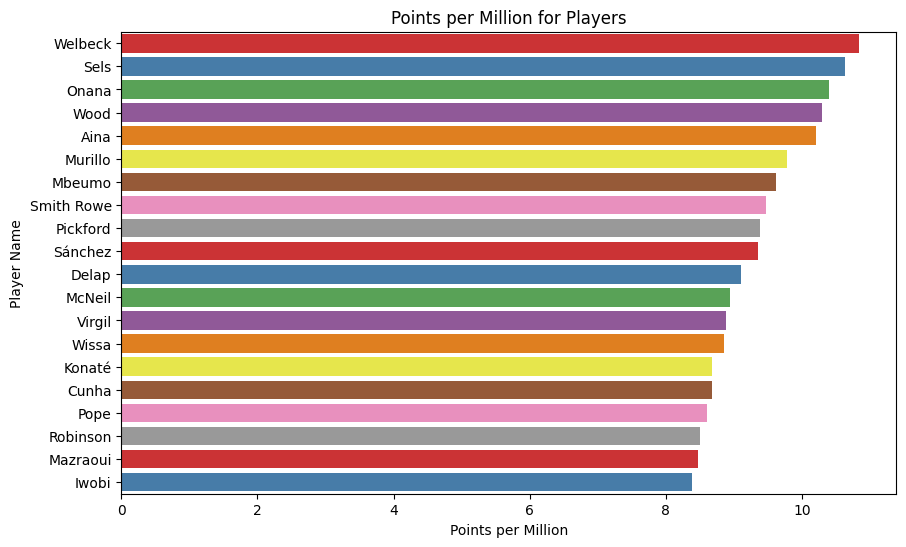

In [109]:
top_20 = points_per_mil_df.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='points_per_mil', y='web_name', data=top_20, palette='Set1')
plt.title("Points per Million for Players")
plt.xlabel("Points per Million")
plt.ylabel("Player Name")
plt.show()

Comparing the performance of premium players against budget players to see if high-cost players justify their price.

In [110]:
query = """
    SELECT 
        p.position_name,
        pl.web_name,
        pl.now_cost,
        pl.total_points,
        (pl.total_points / pl.now_cost) AS points_per_mil,
        CASE 
            WHEN p.position_name = 'Goalkeeper' AND pl.now_cost >= 5.5 THEN 'Premium'
            WHEN p.position_name = 'Goalkeeper' AND pl.now_cost <= 4.5 THEN 'Budget'
            WHEN p.position_name = 'Goalkeeper' AND pl.now_cost > 4.5 AND pl.now_cost < 5.5 THEN 'Mid-Priced'
            
            WHEN p.position_name = 'Defender' AND pl.now_cost >= 6.0 THEN 'Premium'
            WHEN p.position_name = 'Defender' AND pl.now_cost <= 4.5 THEN 'Budget'
            WHEN p.position_name = 'Defender' AND pl.now_cost > 4.5 AND pl.now_cost < 6.0 THEN 'Mid-Priced'
            
            WHEN p.position_name = 'Midfielder' AND pl.now_cost >= 9.5 THEN 'Premium'
            WHEN p.position_name = 'Midfielder' AND pl.now_cost <= 6.5 THEN 'Budget'
            WHEN p.position_name = 'Midfielder' AND pl.now_cost > 6.5 AND pl.now_cost < 9.5 THEN 'Mid-Priced'
            
            WHEN p.position_name = 'Forward' AND pl.now_cost >= 8.5 THEN 'Premium'
            WHEN p.position_name = 'Forward' AND pl.now_cost <= 6.0 THEN 'Budget'
            WHEN p.position_name = 'Forward' AND pl.now_cost > 6.0 AND pl.now_cost < 8.5 THEN 'Mid-Priced'
        END AS cost_category
    FROM players pl
    JOIN positions p ON pl.position_id = p.position_id
    WHERE pl.now_cost > 0
    ORDER BY points_per_mil DESC;
"""
cost_comparison_by_position_df = pd.read_sql_query(query, con)
print(cost_comparison_by_position_df)

    position_name     web_name  now_cost  total_points  points_per_mil  \
0         Forward      Welbeck       5.9            64       10.847458   
1      Goalkeeper         Sels       4.7            50       10.638298   
2      Goalkeeper        Onana       5.1            53       10.392157   
3         Forward         Wood       6.6            68       10.303030   
4        Defender         Aina       4.7            48       10.212766   
..            ...          ...       ...           ...             ...   
271      Defender    Estupiñan       5.0             6        1.200000   
272    Midfielder      Álvarez       5.0             6        1.200000   
273    Midfielder  Ward-Prowse       6.2             7        1.129032   
274      Defender   Woolfenden       4.0             4        1.000000   
275      Defender     Mosquera       3.9             3        0.769231   

    cost_category  
0          Budget  
1      Mid-Priced  
2      Mid-Priced  
3      Mid-Priced  
4      Mid-

Out of the top 20 players based on points per million - 13 are from the mid-priced group, 6 are from the budget group and only one player (which is the only outperforming outlier from the defender position) is from the premium category. So as for the value for money, considering that 19 players out of top 20 are from budget or mid-priced category, it is reasonable to assume that those groupd provide the best value for money as of now.

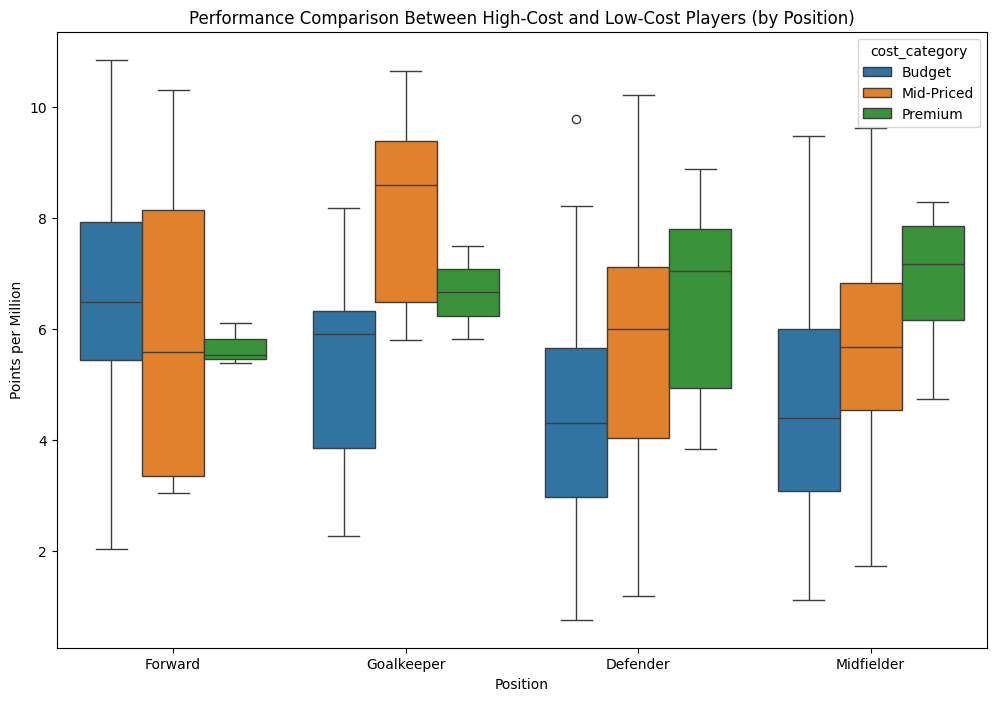

In [111]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='position_name', y='points_per_mil', hue='cost_category', data=cost_comparison_by_position_df)
plt.title("Performance Comparison Between High-Cost and Low-Cost Players (by Position)")
plt.xlabel("Position")
plt.ylabel("Points per Million")
plt.show()

Whilst analysing the performance differences players from different categories, it is noted that on average premium midfielders and defenders are offering the best mean performance, followed by mid-priced and then budget players. On the other hand, situation is different for goalkeepers and forwards. As for the goalkeepers, mid-priced options offer better points return than premium ones. Looking at the bidget options, this distrubution is completely understandable as there are pretty much no starters at the minimal price of the 4.0 million, whereas 4.5 million goalkeepers are less reliable. Analyzing the forward distributions, premium ones have the lowest mean and distribution, but it is worth to mention that there is limited amount of premium options this season. At the same time there are plenty of mid-price options, as it is seen from the boxplot, but still the mean of the budget ones is higher, which should be credited for the performance of specific individuals (for example Danny Welbeck has the highest points-to-million ratio).

Next four visualizations show top 10 players ranked by points-to-million ratio by position this season

In [112]:
goalkeepers_df = points_per_mil_df[points_per_mil_df['position_name'] == 'Goalkeeper'].head(10)
defenders_df = points_per_mil_df[points_per_mil_df['position_name'] == 'Defender'].head(10)
midfielders_df = points_per_mil_df[points_per_mil_df['position_name'] == 'Midfielder'].head(10)
forwards_df = points_per_mil_df[points_per_mil_df['position_name'] == 'Forward'].head(10)

C:\Users\VS\AppData\Local\Temp\ipykernel_8840\1740526080.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='points_per_mil', y='web_name', data=goalkeepers_df, palette='Set1')


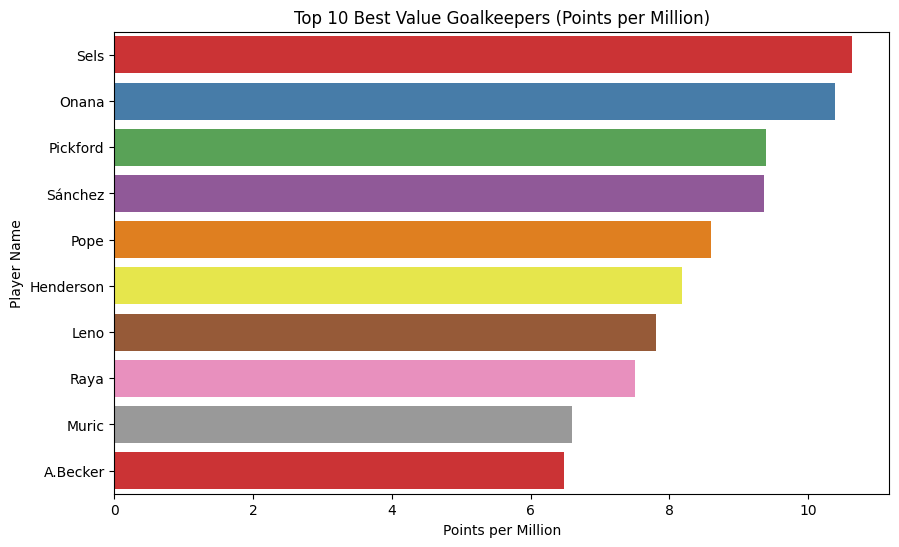

In [113]:
plt.figure(figsize=(10, 6))
sns.barplot(x='points_per_mil', y='web_name', data=goalkeepers_df, palette='Set1')
plt.title("Top 10 Best Value Goalkeepers (Points per Million)")
plt.xlabel("Points per Million")
plt.ylabel("Player Name")
plt.show()

C:\Users\VS\AppData\Local\Temp\ipykernel_8840\1424313404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='points_per_mil', y='web_name', data=defenders_df, palette='Set1')


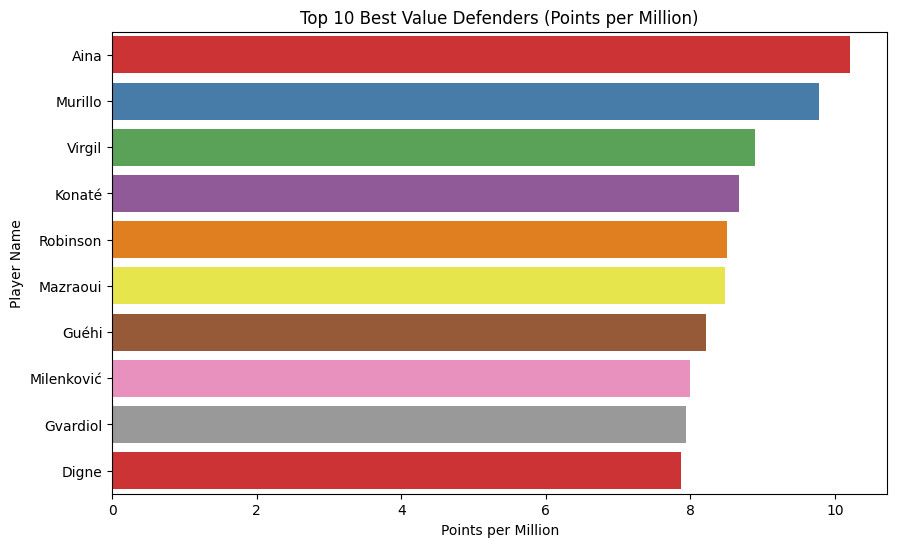

In [114]:
plt.figure(figsize=(10, 6))
sns.barplot(x='points_per_mil', y='web_name', data=defenders_df, palette='Set1')
plt.title("Top 10 Best Value Defenders (Points per Million)")
plt.xlabel("Points per Million")
plt.ylabel("Player Name")
plt.show()

C:\Users\VS\AppData\Local\Temp\ipykernel_8840\886080134.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='points_per_mil', y='web_name', data=midfielders_df, palette='Set1')


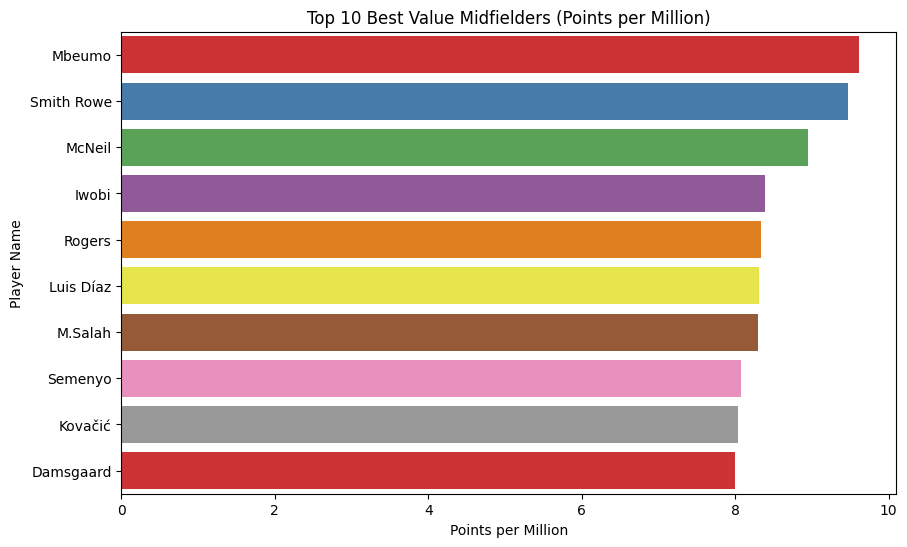

In [115]:
plt.figure(figsize=(10, 6))
sns.barplot(x='points_per_mil', y='web_name', data=midfielders_df, palette='Set1')
plt.title("Top 10 Best Value Midfielders (Points per Million)")
plt.xlabel("Points per Million")
plt.ylabel("Player Name")
plt.show()

C:\Users\VS\AppData\Local\Temp\ipykernel_8840\945877538.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='points_per_mil', y='web_name', data=forwards_df, palette='Set1')


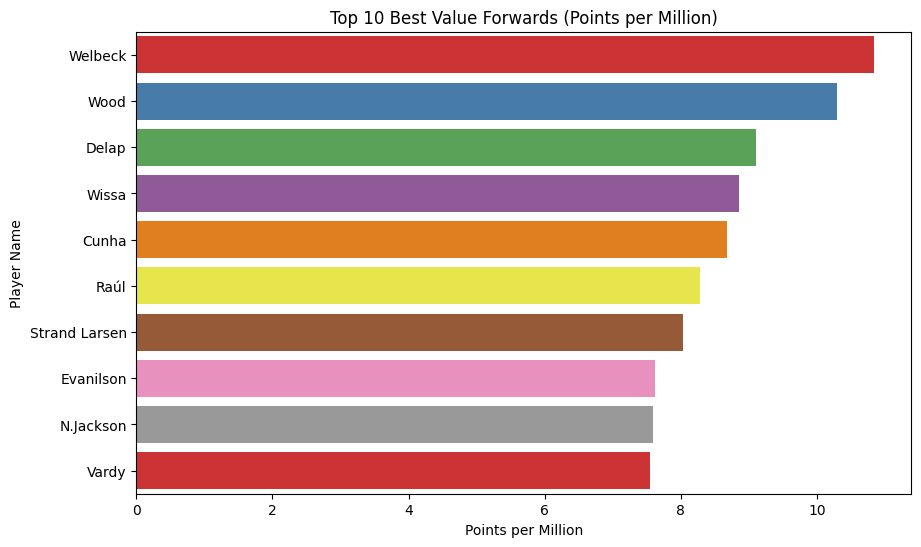

In [116]:
plt.figure(figsize=(10, 6))
sns.barplot(x='points_per_mil', y='web_name', data=forwards_df, palette='Set1')
plt.title("Top 10 Best Value Forwards (Points per Million)")
plt.xlabel("Points per Million")
plt.ylabel("Player Name")
plt.show()

### Optimal Budget Allocation Across Positions

Determine the optimal allocation of FPL budget across the four positions based on their current performance and cost efficiency to improve better budget management.

Budget Distribution: Calculate the average cost for players in each position to understand budget requirements.
Cost Efficiency: Compare points-per-cost across positons to identify where to invest more budget.


Calculating the average cost for each position

In [117]:
query_budget_distribution = """
    SELECT 
        p.position_name,
        AVG(pl.now_cost) AS avg_cost
    FROM players pl
    JOIN positions p ON pl.position_id = p.position_id
    GROUP BY p.position_name;
"""
budget_distribution_df = pd.read_sql_query(query_budget_distribution, con)
print(budget_distribution_df)

  position_name  avg_cost
0      Defender  4.675258
1       Forward  6.746429
2    Goalkeeper  4.754545
3    Midfielder  5.739535


C:\Users\VS\AppData\Local\Temp\ipykernel_8840\1213150421.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='position_name', y='avg_cost', data=budget_distribution_df, palette='Set1')


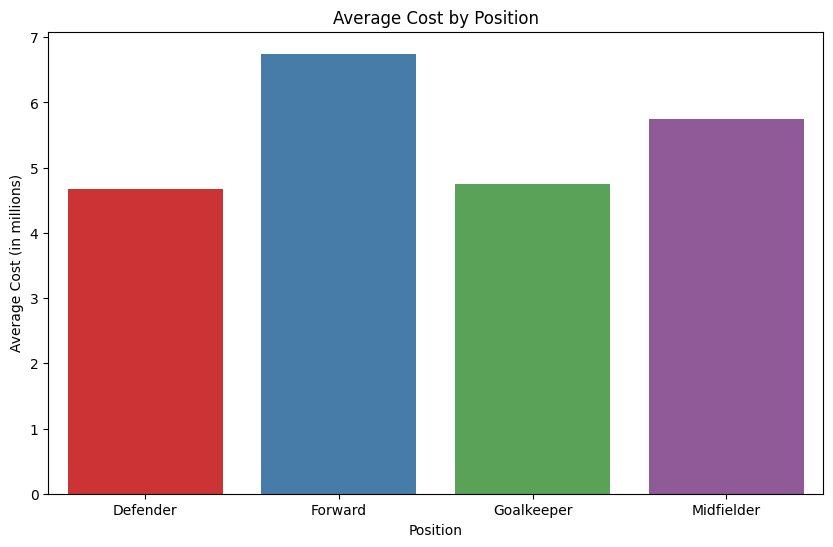

In [118]:
plt.figure(figsize=(10, 6))
sns.barplot(x='position_name', y='avg_cost', data=budget_distribution_df, palette='Set1')
plt.title('Average Cost by Position')
plt.xlabel('Position')
plt.ylabel('Average Cost (in millions)')
plt.show()

Calculating average points per million

In [119]:
query_cost_efficiency = """
    SELECT 
        p.position_name,
        AVG((pl.total_points / pl.now_cost)) AS avg_points_per_cost
    FROM players pl
    JOIN positions p ON pl.position_id = p.position_id
    GROUP BY p.position_name;
"""
cost_efficiency_df = pd.read_sql_query(query_cost_efficiency, con)
print(cost_efficiency_df)

  position_name  avg_points_per_cost
0      Defender             4.920855
1       Forward             6.121218
2    Goalkeeper             6.610160
3    Midfielder             4.806337


C:\Users\VS\AppData\Local\Temp\ipykernel_8840\3101312581.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='position_name', y='avg_points_per_cost', data=cost_efficiency_df, palette='Set1')


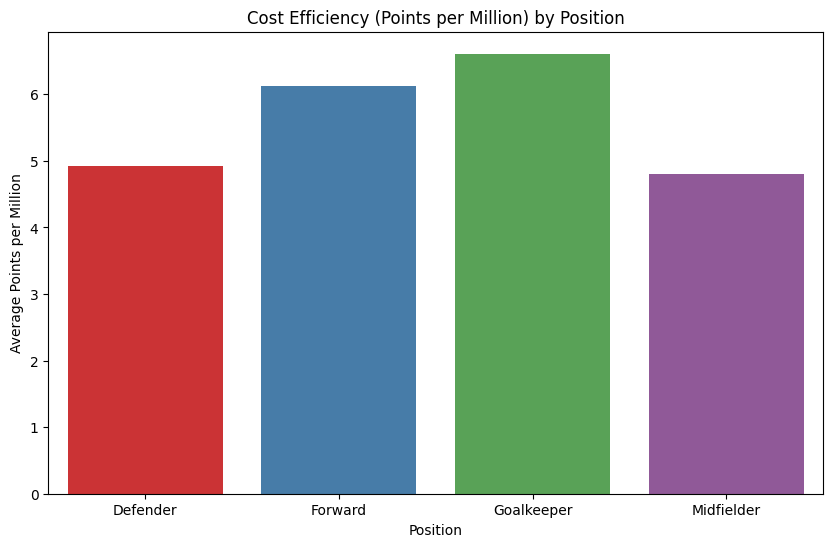

In [120]:
plt.figure(figsize=(10, 6))
sns.barplot(x='position_name', y='avg_points_per_cost', data=cost_efficiency_df, palette='Set1')
plt.title('Cost Efficiency (Points per Million) by Position')
plt.xlabel('Position')
plt.ylabel('Average Points per Million')
plt.show()

### Consistency of Players Within the Season

Identify players who have been consistent performers each gameweek, focusing on those with minimal variance in their weekly points in order to find the players that can be relied on.

Calculate the standard deviation of each player's weekly points to measure consistency

In [123]:
query = """
    SELECT 
        pl.player_id,
        pl.web_name,
        p.position_name,
        plgw.gameweek,
        plgw.total_points
    FROM Players pl
    JOIN Gameweeks plgw ON pl.player_id = plgw.player_id
    JOIN Positions p ON pl.position_id = p.position_id
    ORDER BY pl.player_id, plgw.gameweek;
"""
player_points_df = pd.read_sql_query(query, con)
print(player_points_df.head())

   player_id web_name position_name  gameweek  total_points
0          3  Gabriel      Defender         1             6
1          3  Gabriel      Defender         2             6
2          3  Gabriel      Defender         3             2
3          3  Gabriel      Defender         4            15
4          3  Gabriel      Defender         5             7


In [124]:
player_stats_df = player_points_df.groupby(['player_id', 'web_name', 'position_name'])['total_points'].agg(points_stddev='std', avg_points='mean').reset_index()
print(player_stats_df.head())

   player_id    web_name position_name  points_stddev  avg_points
0          3     Gabriel      Defender       4.253341    4.090909
1          4     Havertz       Forward       3.709938    4.181818
2          6    J.Timber      Defender       1.990888    2.181818
3          9  Martinelli    Midfielder       3.608072    4.272727
4         11     Nketiah       Forward       0.943880    1.090909


Scatterplot is being used to plot the data about all the players

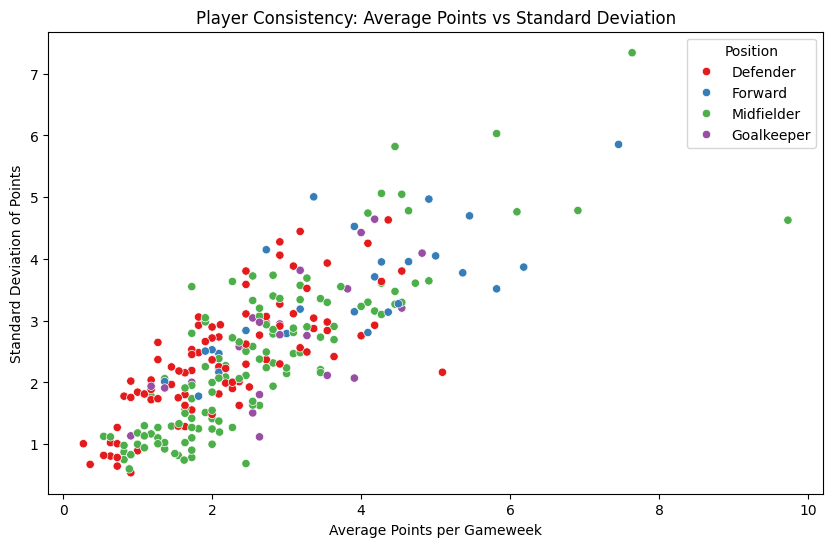

In [125]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_points', y='points_stddev', data=player_stats_df, hue='position_name', palette='Set1')
plt.title('Player Consistency: Average Points vs Standard Deviation')
plt.xlabel('Average Points per Gameweek')
plt.ylabel('Standard Deviation of Points')
plt.legend(title='Position')
plt.show()

In order to find the most consistent performers, we can look at the players with smaller standard deviation and higher average points per gameweek

In [126]:
consistent_players = player_stats_df[
    (player_stats_df['points_stddev'] <= 5) & 
    (player_stats_df['avg_points'] >= 5)      
]
print(consistent_players)

     player_id   web_name position_name  points_stddev  avg_points
8           17       Saka    Midfielder       4.763498    6.090909
27          58    Watkins       Forward       4.049691    5.000000
46          99     Mbeumo    Midfielder       4.784444    6.909091
64         148    Welbeck       Forward       3.516196    5.818182
74         180  N.Jackson       Forward       4.698162    5.454545
143        328    M.Salah    Midfielder       4.627978    9.727273
148        339     Virgil      Defender       2.165851    5.090909
200        447       Wood       Forward       3.868286    6.181818
237        541      Cunha       Forward       3.775519    5.363636


As a result, there are not that many consistent performers across the start of the season. There are only 9 players with the standard deviation of <= 5 and average points per gameweek of >= 5.